In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from divopt.utils import calculate_properties, list_cache, pool_wrapper

/tmp/ipykernel_5356/3095794649.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
divopt_path: str = os.environ.get("DIVOPTPATH")  # type: ignore
if divopt_path is None:
    raise ValueError("DIVOPTPATH environment variable not set")

calculate_properties_list = list_cache(pool_wrapper(calculate_properties))

In [4]:
smiles_fname = os.path.join(divopt_path, "data/guacamol_v1_all.smiles")
df = pd.read_csv(smiles_fname, header=None, names=["smiles"])

In [5]:
# calculate prop_df if not already calculated and stored as file
def set_to_string(x):
    return json.dumps(list(x))


def string_to_set(s):
    return set(json.loads(s))


prop_df_path = os.path.join(divopt_path, "data/guacamol_v1_all_properties.csv")
if os.path.isfile(prop_df_path):
    prop_df = pd.read_csv(prop_df_path)
    prop_df["ECFP4bits"] = prop_df["ECFP4bits"].apply(string_to_set)
else:
    print("Calculating and saving properties..")
    prop_df = pd.DataFrame(calculate_properties_list(df["smiles"].to_list()))
    prop_df["ECFP4bits"] = prop_df["ECFP4bits"].apply(set_to_string)
    prop_df.to_csv(prop_df_path, index=False)
    prop_df["ECFP4bits"] = prop_df["ECFP4bits"].apply(string_to_set)

Calculating and saving properties..


In [29]:
# find two-sided threshold at a given percentile
percentile = 0.99
# percentile = 0.8
half_percentile = (1 - percentile) / 2
quantiles = [half_percentile, 1 - half_percentile]
thresholds = {}
for prop in ["MW", "LogP"]:
    lower, upper = prop_df[prop].quantile(quantiles).values
    thresholds[prop] = (lower, upper)

# one-sided threshold for qed
thresholds["QED"] = (prop_df["QED"].quantile(1 - percentile), 1)
thresholds

{'MW': (157.11027872, 761.3414418201),
 'LogP': (-2.0107999999999997, 8.831511500000007),
 'QED': (0.0818088806773067, 1)}

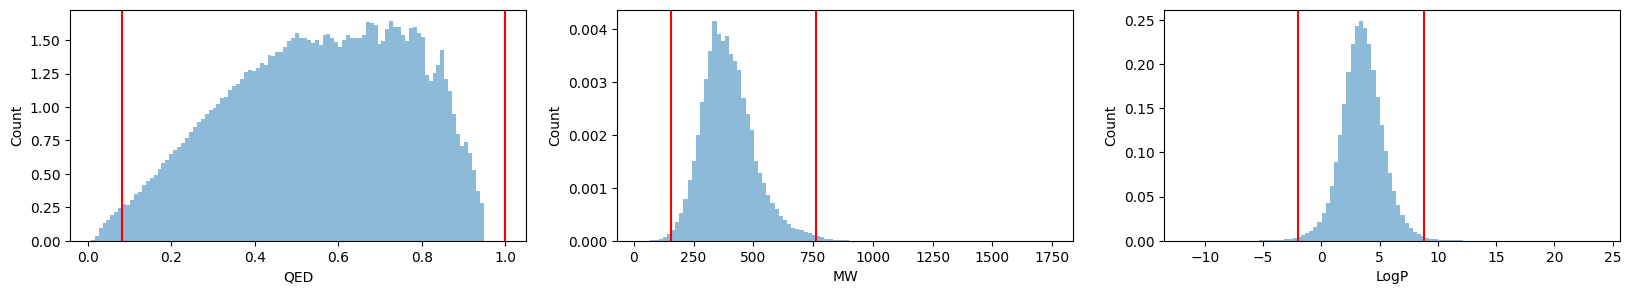

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(20, 3))
for prop, ax in zip(["QED", "MW", "LogP"], axes):
    ax.hist(prop_df[prop], bins=100, alpha=0.5, density=True)
    ax.set_xlabel(prop)
    ax.set_ylabel("Count")
    for threshold in thresholds[prop]:
        ax.axvline(threshold, color="red")

## Create filter for exotic fingerprints
- Load Chembl molecules
- Split them into a large reference set and a smaller calibration set
- Determine threshold at a 99.9% level

In [31]:
fps = prop_df["ECFP4bits"].to_numpy()
fps1 = fps[:1_300_000]
fps2 = fps[1_300_000:]

In [32]:
# print lengths of fingerprint arrays including names
print("Total number of fingerprints: ", len(fps))
print("Number of fingerprints for known bits: ", len(fps1))
print("Number of fingerprints to calibrate threshold: ", len(fps2))

Total number of fingerprints:  1591378
Number of fingerprints for known bits:  1300000
Number of fingerprints to calibrate threshold:  291378


No saturation can be oberved. New bits are added with every new molecule.
Therefore there is no natural number of reference compounds to choose.


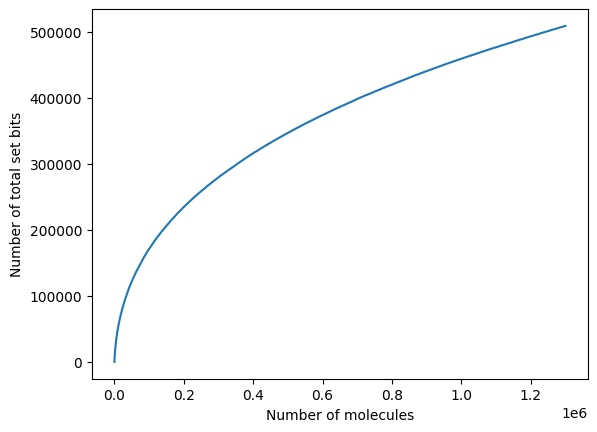

In [33]:
known_bits = set()
n_bits = [0]
for fp_bits in fps1:
    known_bits.update(fp_bits)
    n_bits.append(len(known_bits))
plt.plot(n_bits)
# create labels
plt.xlabel("Number of molecules")
plt.ylabel("Number of total set bits")
print(
    """No saturation can be oberved. New bits are added with every new molecule.
Therefore there is no natural number of reference compounds to choose."""
)

In [36]:
def check_against_known(fp_bits, known_bits):
    return len(known_bits.intersection(fp_bits)) / len(fp_bits)


# Set this to true to write the files used in optimization
write_outputs = True

chembl_ratios = [check_against_known(fp, known_bits) for fp in fps2]

threshold_value = np.quantile(chembl_ratios, 1 - percentile)
print(
    f"Threshold such that {(1-percentile)*100:.1f}% of 'new' Chembl molecules have a fraction of known \
bits above this threshold: {threshold_value:.3f}"
)
thresholds["ECFP4bits"] = (threshold_value, 1.1)

Threshold such that 1.0% of 'new' Chembl molecules have a fraction of known bits above this threshold: 0.917


In [37]:
# Set this to true to write the files used in optimization
write_outputs = True

scoring_function_dir = os.path.join(divopt_path, "data/scoring_functions")
known_bits_fn = os.path.join(scoring_function_dir, "guacamol_known_bits.json")
if write_outputs:
    with open(known_bits_fn, "w") as f:
        json.dump(list(known_bits), f)

thresholds_fn = os.path.join(scoring_function_dir, "guacamol_thresholds.json")
if write_outputs:
    with open(thresholds_fn, "w") as f:
        json.dump(thresholds, f)

In [13]:
from divopt.scoring import ExoticFingerprintRatio

exotic_fingerprint_calculator = ExoticFingerprintRatio(known_bits_fn)

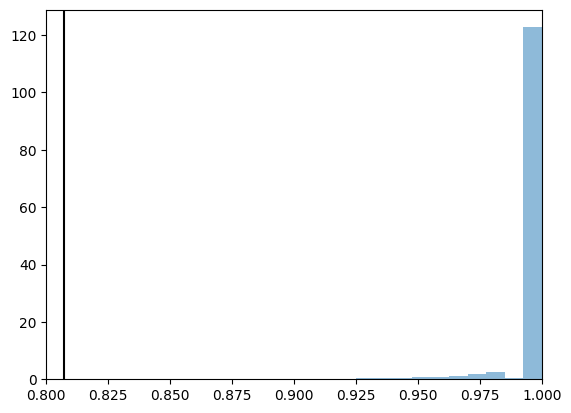

In [14]:
chembl_ratios = [exotic_fingerprint_calculator.get_ratio(fp) for fp in fps2]
plt.hist(chembl_ratios, alpha=0.5, density=True, bins=100, label="chembl")
plt.xlim(0.8, 1.0)
plt.axvline(float(threshold_value), color="black", label="threshold")